# AHRS Data Viewer

## Importing Data

Enter the path to the folder containing your datasets below (the data can be in subfolders, but no other files may reside in this directory). The data is expected to be in CSV format.

In [1]:
# Imports
%config IPCompleter.greedy=True
%matplotlib notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Set up input field
data_dir_input = widgets.Text()
# Display input field
widgets.HBox([widgets.Label('Path to data directory'), data_dir_input])

In [2]:
# Setup a few things before we loop through our files
data_list = {} # dictionary to hold our data sets / file names
NUM_HEADER_LINES = 4 # number of header lines in the file

# Loop through our files to parse data
for root, dirs, files in os.walk(data_dir_input.value, topdown=False):
    for name in files:
        # Fill in our array
        data_list[name] = (np.genfromtxt(os.path.join(root, name), delimiter=',', dtype='f4', 
                                          skip_header=NUM_HEADER_LINES, encoding='ascii'))
        

## Plot the raw data

<IPython.core.display.Javascript object>


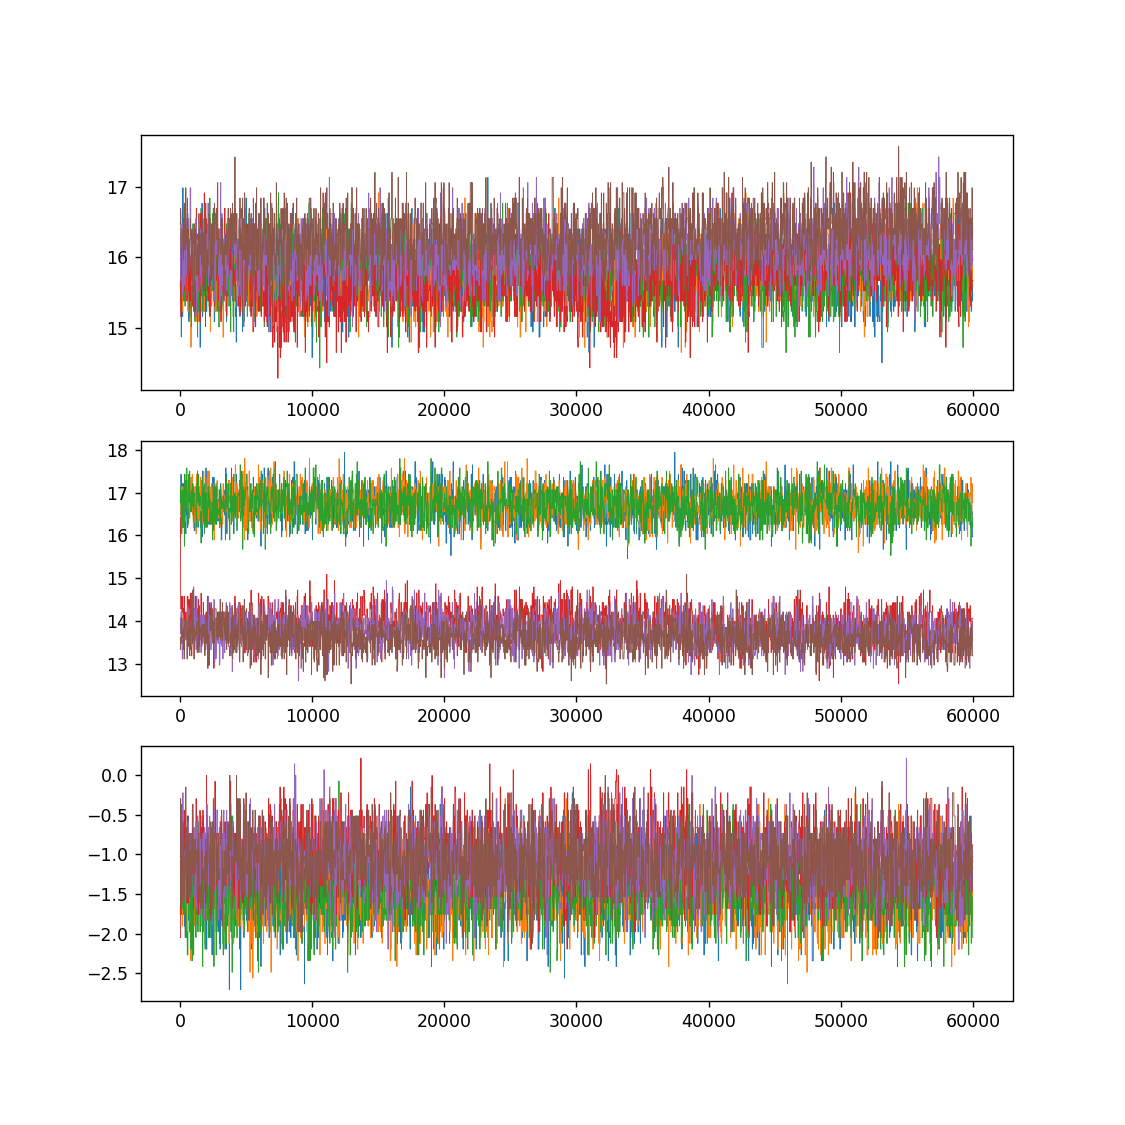

In [65]:
# Setup figure
plt.rcParams['figure.figsize'] = [9, 9]
plt.rcParams['lines.linewidth'] = 0.5
unfiltered_fig = plt.figure()
# Setup individual plots
unfiltered_axes = []
unfiltered_axes.append(unfiltered_fig.add_subplot(3,1,1))
unfiltered_axes.append(unfiltered_fig.add_subplot(3,1,2))
unfiltered_axes.append(unfiltered_fig.add_subplot(3,1,3))

# Data type will be selected via a single selection list
# we'll use a dictionary to keep track of each column and it's data type
data_type_columns = {'Accelerometer' : [1, 2, 3], 'Gyroscope' : [4, 5, 6], 'Magnetometer' : [7, 8, 9]}
data_type_select = widgets.Select(
    options = data_type_columns.keys(),
    description = 'Data type',
    disabled = False,
    layout = widgets.Layout(width = "300px")           
)

# Data sets will be selected via a multiple selection list
unfiltered_data_select = widgets.SelectMultiple(
    options= data_list.keys(),
    description='Data sets',
    disabled = False,
    layout = widgets.Layout(width = "300px", height = "500px" )
)

# Update plots button
update_plots_btn = widgets.Button(
    description="Update plots",
    disabled = False,
    layout = widgets.Layout(margin = "10px 0 20px 90px", border = "1px solid gray")
)

def update_plots(b):
    # Clear out old lines
    for ax in unfiltered_axes:
        ax.cla()
        
    # For each data set selected
    for item in unfiltered_data_select.value:
        # Iterator to plot to the correct graph
        i = 0
        # For each column representing the data type
        for column in data_type_columns[data_type_select.value]:
            unfiltered_axes[i].plot(data_list[item][:,0], data_list[item][:,column])
            i += 1
            
    unfiltered_fig.show()
    
update_plots_btn.on_click(update_plots)

# Display our widgets
widgets.VBox([update_plots_btn, widgets.HBox([data_type_select, unfiltered_data_select])])